## Causal Tracing (ROME)

Causal tracing was a methodology for locating where facts are stored in transformer LMs, introduced in the paper ["Locating and Editing Factual Associations in GPT" (Meng et al., 2023)](https://arxiv.org/abs/2202.05262). In this notebook, we will implement their method using this library and replicate the first causal tracing example in the paper (full figure 1 on page 2).


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/advance_tutorials/Causal_Tracing.ipynb)


In [1]:
__author__ = "Aryaman Arora"
__version__ = "11/08/2023"

### Set-up


In [2]:
import pyvene

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [3]:
import torch
import pandas as pd
import numpy as np
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention, Intervention,
    RepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    LocalistRepresentationIntervention
)
from pyvene import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    xlab, ylab, ylim,
    scale_y_discrete, scale_y_continuous, ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm
import os

titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
} 

In [4]:
import pandas as pd
pd.read_parquet('data/train-00000-of-00001.parquet', engine='pyarrow')

,question,answer,passage
0,do iran and afghanistan speak the same language,True,"Persian (/ˈpɜːrʒən, -ʃən/), also known by its ..."
1,do good samaritan laws protect those who help ...,True,Good Samaritan laws offer legal protection to ...
2,is windows movie maker part of windows essentials,True,Windows Movie Maker (formerly known as Windows...
3,is confectionary sugar the same as powdered sugar,True,"Powdered sugar, also called confectioners' sug..."
4,is elder scrolls online the same as skyrim,False,As with other games in The Elder Scrolls serie...
...,...,...,...
9422,is a us district court a federal court,True,The United States district courts are the gene...
9423,can a tenant get a restraining order against a...,True,"If a landlord is found to be retaliating, he o..."
9424,is the golden state warriors in the playoffs,True,The Warriors went into the 2018 playoffs as th...
9425,downton abbey will there be a season 7,False,Downton Abbey is a British period drama televi...


### Factual recall

Let's set up the model (gpt2-xl) and test it on the fact we want to causal trace: "The Space Needle is in downtown **Seattle**".


In [5]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"
config, tokenizer, gpt = create_gpt2(name="gpt2-xl")
gpt.to(device)

# base = "Topic: Singing in the shower Sentiment: Positive. Topic: Killing people Sentiment:"
base = "Hitler was the leader of the"
inputs = [
    tokenizer(base, return_tensors="pt").to(torch.float32).to(device),
]

print(f'Input: {base}')
print(f'Token length: {len(inputs[0].input_ids[0])}')

res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

Attempting to cast a BatchEncoding to type torch.float32. This is not supported.


loaded model
Input: Hitler was the leader of the
Token length: 7
_German              0.17273233830928802
_Nazi                0.16321046650409698
_National            0.10375089943408966
_Third               0.05386084318161011
_Nazis               0.03301849216222763
_party               0.030300339683890343
_A                   0.017917156219482422
_N                   0.017876841127872467
_F                   0.0162905752658844
_"                   0.015107722021639347


In [6]:
inputs

[{'input_ids': tensor([[17889,  1754,   373,   262,  3554,   286,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}]

In [7]:
# print from input every token and separate by /n
for token in inputs[0].input_ids[0]:
    print(tokenizer.decode(token))

Hit
ler
 was
 the
 leader
 of
 the


## Corrupted run

The first step in implementing causal tracing is to corrupt the input embeddings for the subject tokens by adding Gaussian noise to them. In Meng et al., the standard deviation of the Gaussian we sample from is computed as thrice the standard deviation of embeddings over a big dataset. We encode this as a constant, `self.noise_level`.

Note that the `source` argument is ignored unlike in causal interventions, since we are adding noise without reference to any other input.

Our intervention config intervenes on the `block_input` of the 0th layer, i.e. the embeddings.


In [15]:
class NoiseIntervention(ConstantSourceIntervention, LocalistRepresentationIntervention):
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = embed_dim
        rs = np.random.RandomState(1)
        prng = lambda *shape: rs.randn(*shape)
        self.noise = torch.from_numpy(prng(1, 2, embed_dim)).to(device)           # HERE
        self.noise_level = 0.13462981581687927

    def forward(self, base, source=None, subspaces=None):
        base[..., : self.interchange_dim] += self.noise * self.noise_level
        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"


def corrupted_config(model_type):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                0,              # layer
                "block_input",  # intervention type
            ),
        ],
        intervention_types=NoiseIntervention,
    )
    return config

Let's check that this reduced the probability of the output "\_Seattle".


In [17]:
base = tokenizer("Hitler was the leader of the", return_tensors="pt").to(torch.float32).to(device)
config = corrupted_config(type(gpt))
intervenable = IntervenableModel(config, gpt)
_, counterfactual_outputs = intervenable(
    base, unit_locations={"base": ([[[0, 1]]])}
)
distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

Attempting to cast a BatchEncoding to type torch.float32. This is not supported.


_German              0.023986341431736946
_party               0.02213403582572937
_"                   0.021758506074547768
_opposition          0.021678132936358452
_United              0.020237183198332787
_Nazi                0.01792212575674057
_Soviet              0.01664469949901104
_Democratic          0.01341939065605402
_U                   0.012215803377330303
_Communist           0.01186090987175703


### Restored run

We now make a config that performs the following:

1. Corrupt input embeddings for some positions.
2. Restore the hidden state at a particular layer for some (potentially different positions).

This is how Meng et al. check where in the model the fact moves through.


In [18]:
def restore_corrupted_with_interval_config(
    layer, stream="mlp_activation", window=10, num_layers=48):
    start = max(0, layer - window // 2)
    end = min(num_layers, layer - (-window // 2))
    config = IntervenableConfig(
        representations=[
            RepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
        ] + [
            RepresentationConfig(
                i,       # layer
                stream,  # intervention type
        ) for i in range(start, end)],
        intervention_types=\
            [NoiseIntervention]+[VanillaIntervention]*(end-start),
    )
    return config

Now let's run this over all layers and positions! We will corrupt positions 0, 1, 2, 3 ("The Space Needle", i.e. the subject of the fact) and restore at a single position at every layer.


In [19]:
# should finish within 1 min with a standard 12G GPU
token = tokenizer.encode(" German")[0]
print(token)

2679


In [20]:
if not os.path.exists("output/hitler_pyvene_rome_block_output.csv") or not os.path.exists("output/hitler_pyvene_rome_mlp_activation.csv") or not os.path.exists("output/hitler_pyvene_rome_attention_output.csv"):
    for stream in ["block_output", "mlp_activation", "attention_output"]:
        data = []
        for layer_i in tqdm(range(gpt.config.n_layer)):
            for pos_i in range(7):
                config = restore_corrupted_with_interval_config(
                    layer_i, stream, 
                    window=1 if stream == "block_output" else 10
                )
                n_restores = len(config.representations) - 1
                intervenable = IntervenableModel(config, gpt)
                _, counterfactual_outputs = intervenable(
                    base,
                    [None] + [base]*n_restores,
                    {
                        "sources->base": (
                            [None] + [[[pos_i]]]*n_restores,
                            [[[0, 1]]] + [[[pos_i]]]*n_restores,
                        )
                    },
                )
                distrib = embed_to_distrib(
                    gpt, counterfactual_outputs.last_hidden_state, logits=False
                )
                prob = distrib[0][-1][token].detach().cpu().item()
                data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
        df = pd.DataFrame(data)
        df.to_csv(f"output/hitler_pyvene_rome_{stream}.csv")

  2%|▏         | 1/48 [05:32<4:20:25, 332.46s/it]


KeyboardInterrupt: 

The plot below should now replicate Meng et al.


/opt/miniconda3/envs/py310/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: output/pyvene_rome_block_output.pdf


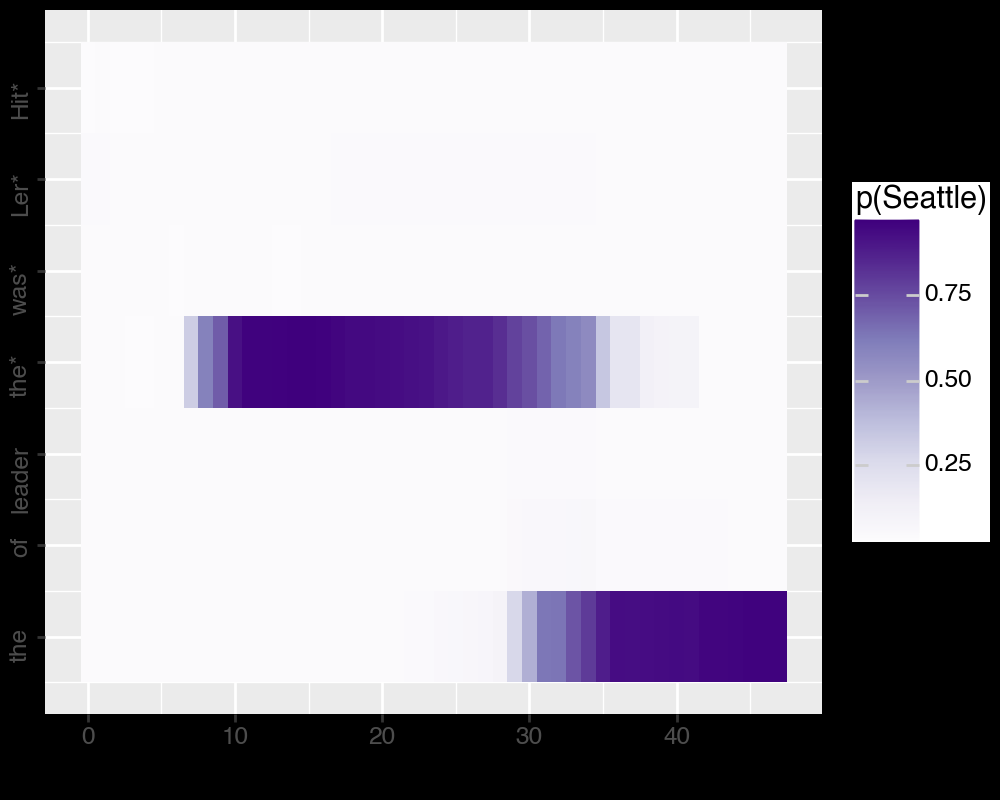

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: output/pyvene_rome_mlp_activation.pdf


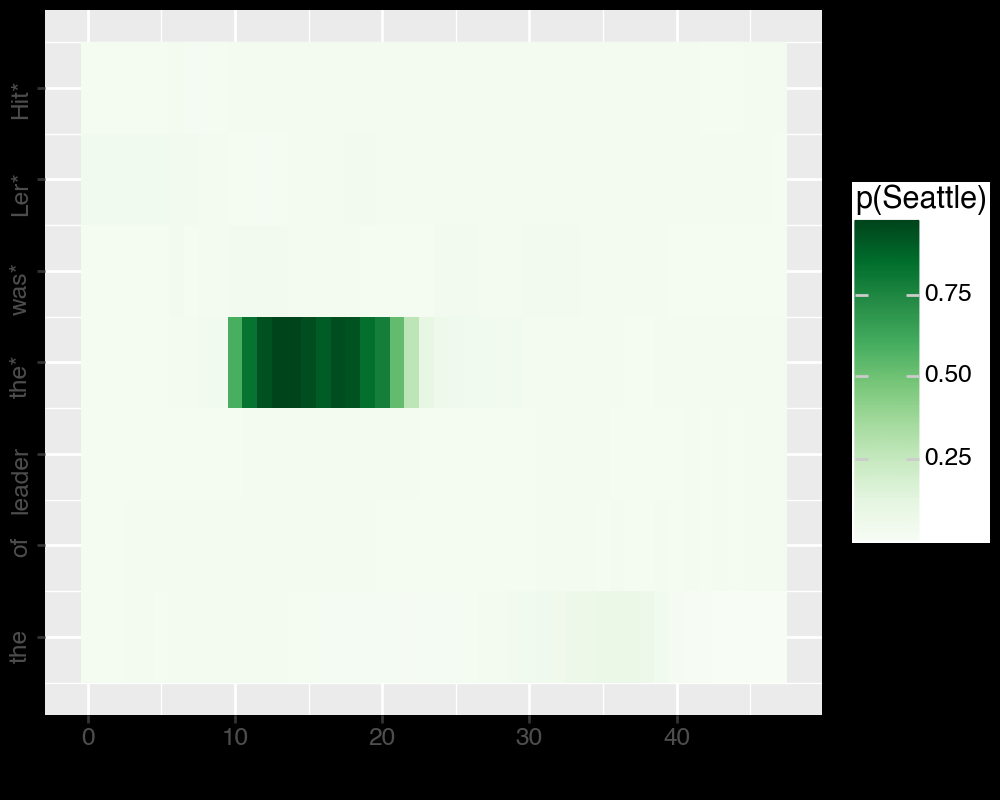

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: output/pyvene_rome_attention_output.pdf


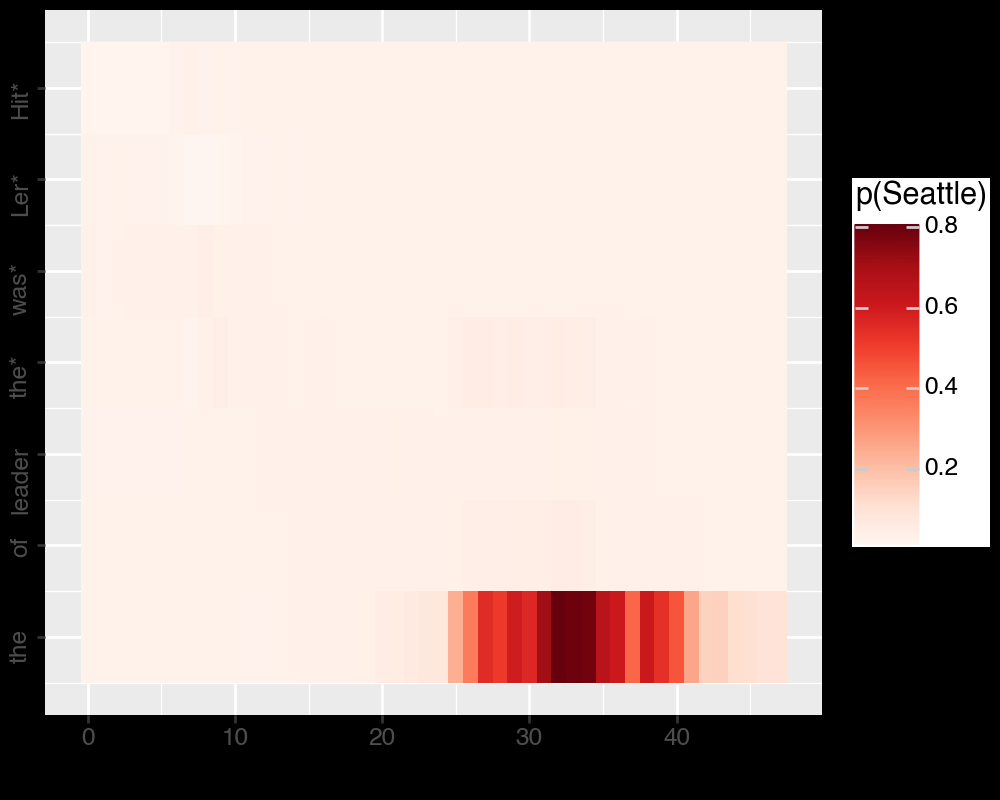

In [13]:
for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"output/hitler_pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df["p(Seattle)"] = df["prob"].astype(float)
    
    custom_labels = ["Hit*", "Ler*", "was*", "the*", "leader", "of", "the"]
    breaks = [0, 1, 2, 3, 4, 5, 6]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))    

        + geom_tile(aes(fill="p(Seattle)"))
        + scale_fill_cmap(colors[stream]) + xlab(titles[stream])
        + scale_y_reverse(
            limits = (-0.5, 6.5), 
            breaks=breaks, labels=custom_labels) 
        + theme(figure_size=(5, 4)) + ylab("") 
        + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
    )
    ggsave(
        plot, filename=f"output/hitler_pyvene_rome_{stream}.pdf", dpi=200
    )
    display(plot)